In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_cerebras import ChatCerebras
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [5]:
parent_llm=ChatCerebras(model='llama-3.3-70b')
subgraph_llm=ChatCerebras(model='llama-3.3-70b')

### build first subgraph

In [6]:
class SubState(TypedDict):

    input_text: str
    translated_text: str

In [7]:

def translate_text(state: SubState):

    prompt = f"""
            Translate the following text to Hindi.
            Keep it natural and clear. Do not add extra content.

            Text:
            {state["input_text"]}""".strip()
    
    translated_text = subgraph_llm.invoke(prompt).content

    return {'translated_text': translated_text}

In [8]:

subgraph_builder = StateGraph(SubState)

subgraph_builder.add_node('translate_text', translate_text)

subgraph_builder.add_edge(START, 'translate_text')
subgraph_builder.add_edge('translate_text', END)

subgraph = subgraph_builder.compile()

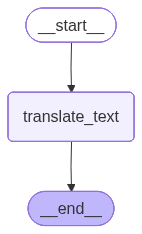

In [9]:
subgraph

### now build parent graph

In [10]:
class ParentState(TypedDict):

    question: str
    answer_eng: str
    answer_hin: str

In [11]:

def generate_answer(state: ParentState):

    answer = parent_llm.invoke(f"You are a helpful assistant. Answer clearly.\n\nQuestion: {state['question']}").content
    return {'answer_eng': answer}

In [12]:

def translate_answer(state: ParentState):

    # call the subgraph
    result = subgraph.invoke({'input_text': state['answer_eng']})

    return {'answer_hin': result['translated_text']}

In [14]:

parent_builder = StateGraph(ParentState)

parent_builder.add_node("answer", generate_answer)
parent_builder.add_node("translate", translate_answer)

parent_builder.add_edge(START, 'answer')
parent_builder.add_edge('answer', 'translate')
parent_builder.add_edge('translate', END)

graph = parent_builder.compile()


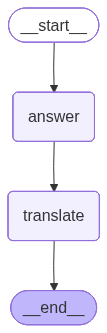

In [15]:
graph

In [16]:
graph.invoke({'question': 'What is quantum physics'})


{'question': 'What is quantum physics',
 'answer_eng': '**Quantum Physics: A Brief Overview**\n\nQuantum physics, also known as quantum mechanics, is a branch of physics that studies the behavior of matter and energy at an atomic and subatomic level. At these scales, classical physics laws do not apply, and strange, seemingly random phenomena occur.\n\n**Key Principles:**\n\n1. **Wave-Particle Duality**: Quantum objects, such as electrons, can exhibit both wave-like and particle-like behavior.\n2. **Uncertainty Principle**: It is impossible to know certain properties of a quantum object, like position and momentum, simultaneously with infinite precision.\n3. **Superposition**: Quantum objects can exist in multiple states simultaneously, which is known as a superposition of states.\n4. **Entanglement**: Quantum objects can become "entangled," meaning their properties are connected, even when separated by large distances.\n\n**Quantum Physics Explained:**\n\nImagine you have a coin. In c